**Machine Learning with tidymodels**

In the fourth problem set you will create pipelines to prepare data-sets and train predictive machine learning models.

To perform your analysis you have to load some libraries. We will use ```tidyverse``` to wrangle the data and ```tidymodels``` to train the models. If you want to use additional libraries you can add them to the following cell:

In [1]:
library(mlbench)
library(tidymodels)
library(tidyverse)
library(workflows)
library(tune)
library(parsnip)
library(yardstick)
library(dplyr)
library(tidyr)
library(glmnet)

## Task 1
**Space Travel Refund Prediction**

The eccentric billionaire Melon Tusk offers space travel for wealthy customers. Unfortunately, the service on the space flights is not always perfect and many customers claim a refund. Your task is to use the data set provided by Melon Tusk to  train a machine learning model predicting if a customer claimed a refund after after the trip. 

Melon provides you with a brief description of the data set:

- PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
- CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- Destination - The planet the passenger will be debarking to.
- Age - The age of the passenger.
- VIP - Whether the passenger has paid for special VIP service during the voyage.
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- Name - The first and last names of the passenger.
- Refunded - Whether the passenger claimed a refund. This is the target, the column you are trying to predict.

First, you have to load the data-set from [github](https://raw.githubusercontent.com/NikoStein/TDS_data/main/melon_tusk.csv). Inspect the data-set and get a first impression of the different variables.

In [2]:
spacetravel <- read.csv('https://raw.githubusercontent.com/NikoStein/TDS_data/main/melon_tusk.csv')
head(spacetravel)

Next, remove identifying variables and split the data into a training and a test set and prepare the training data for cross validation.

In [18]:
spacetravel$Age <- as.numeric(as.character(spacetravel$Age))
spacetravel$RoomService <- as.numeric(as.character(spacetravel$RoomService))
spacetravel$FoodCourt <- as.numeric(as.character(spacetravel$FoodCourt))
spacetravel$ShoppingMall <- as.numeric(as.character(spacetravel$ShoppingMall))
spacetravel$Spa <- as.numeric(as.character(spacetravel$Spa))
spacetravel$VRDeck <- as.numeric(as.character(spacetravel$VRDeck))
spacetravel$Refunded <- as.factor(spacetravel$Refunded)
spacetravel %>%
    select(-PassengerId, -Name, -Cabin) %>%
    mutate_at(vars(RoomService, FoodCourt, ShoppingMall, Spa, VRDeck),
             function(.var) {
                 if_else(condition = (.var == 0),
                        true = as.numeric(NA),
                        false = .var
                        )
             }) -> spacetravel_clean
head(spacetravel_clean)

In [19]:
spacetravel_clean %>% 
  count(Refunded) %>% 
  mutate(prop = n/sum(n))

In [20]:
spacetravel_split <- initial_split(spacetravel_clean, strata = Refunded) # split the data into trainng (75%) and testing (25%)
spacetravel_split
spacetravel_train <- training(spacetravel_split)
spacetravel_test <- testing(spacetravel_split)

Next, you should prepare a recipe to preprocess the data:

In [21]:
set.seed(234)
spacetravel_cv <- vfold_cv(spacetravel_train, v=5)

In [22]:
recipe(Refunded ~ ., 
         data = spacetravel_clean) %>%
    step_dummy(all_nominal_predictors()) %>% 
    step_knnimpute(all_predictors()) %>%
    step_normalize(all_numeric()) -> spacetravel_recipe
spacetravel_recipe

Specify the model (you can try multiple different models) and create a workflow:

In [23]:
logistic_reg() %>%
  set_engine("glm") %>%
  set_mode("classification") -> lr_model

In [24]:
rf_workflow <- workflow() %>%
  add_recipe(spacetravel_recipe) %>%
  add_model(lr_model)

In [25]:
rf_grid <- expand.grid(mtry = c(3, 5), trees = c(100))

Train the model and tune the hyperparameters using cross validation. Subsequently, inspect the results, select the best parameters and finalize the workflow:

In [26]:
rf_workflow %>% 
tune_grid(resamples = spacetravel_cv, #CV object
            grid = rf_grid, # grid of values to try
            metrics = metric_set(accuracy, roc_auc) # metrics we care about
            ) -> rf_tune_results

In [27]:
rf_tune_results %>%
    collect_metrics() %>%
    filter(.metric == "accuracy")

In [28]:
rf_tune_results %>%
  select_best(metric = "accuracy") -> param_final

param_final


rf_workflow %>%
  finalize_workflow(param_final) -> rf_workflow

Finally, train the model on the complete training data and evaluate its performance on the test data.

Note: You should try to build a model with an accuracy of at least 0.75.

In [ ]:
rf_workflow %>%
  # fit on the training set and evaluate on test set
  last_fit(spacetravel_split) -> rf_fit

In [ ]:
rf_fit %>%
    select(-.workflow) %>%
    glimpse()

rf_fit$.predictions

In [ ]:
test_performance <- rf_fit %>% collect_metrics()
test_performance

## Task 2
***Predicting NFL Attendance***

In this task, you should predict the weekly attendance of NFL games based on team records, scores and more. You can download the attendance data [here](https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-02-04/attendance.csv) and the standing [here](https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-02-04/standings.csv). Download, inspect and join both data sets.

Note: You can finde detailed information on the data sets [here](https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-02-04/readme.md#data-dictionary).
Note: There are observations with missing values for the weekly attendance. You can remove these rows.

In [33]:
attendance <- read.csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-02-04/attendance.csv')
#head(attendance)
standing <- read.csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-02-04/standings.csv')
#head(standing)
nfl = left_join(x=attendance,y=standing,by= c("team_name", "team", "year"))
head(nfl)

In [34]:
nfl %>%
    select(-team) %>%
    arrange(-weekly_attendance) %>%
    drop_na(weekly_attendance) -> nfl_data
head(nfl_data)

Use visualization to get familiar with the weekly attendance. To this end, try to replicate the following plot showing the variation of the weekly attendance for the different teams depending accross the seasons.

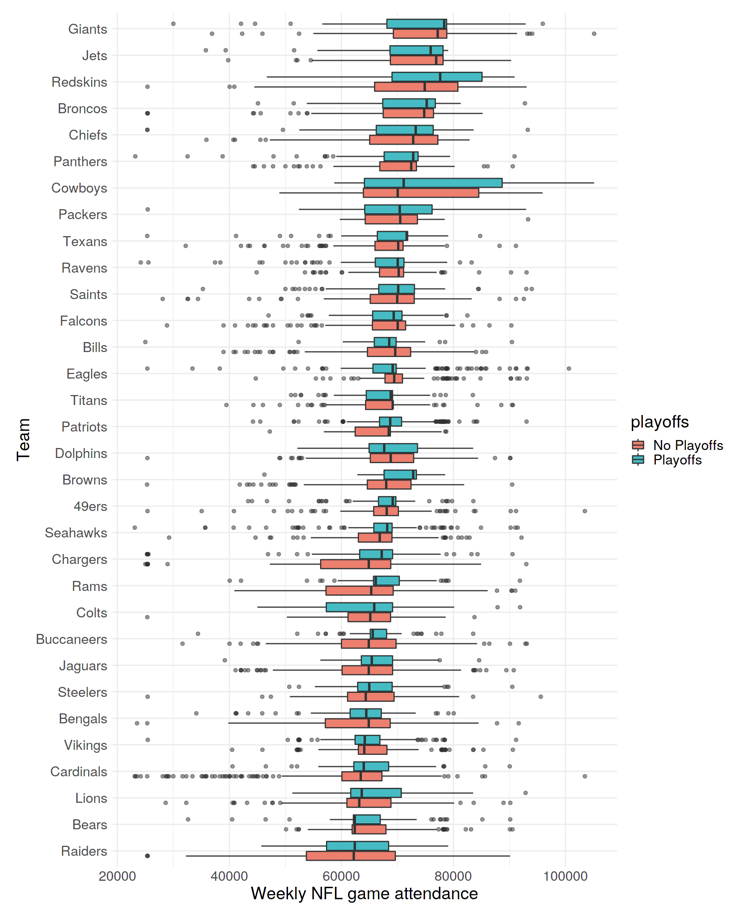

In [35]:
nfl_data %>%
    ggplot(aes(x=weekly_attendance, y=team_name, fill=playoffs)) + 
    geom_boxplot() +
    xlab("Weekly NFL game attendance") + ylab("Team") +
    theme_bw() +
    scale_x_continuous(labels = scales::comma)

Next, you should build a machine learning model to predict the weekly attendance. Remember to use train-test splitting, cross validation, preprocessing and workflows to complete the task.

Note: The resulting model should have an RMSE of 8500 or lower.

In [52]:
#glimpse(nfl_data)
nfl_data %>%
    select(-team_name, -year, -week) -> nfl_clean

nfl_clean$total <- as.numeric(as.character(nfl_clean$total))
nfl_clean$home <- as.numeric(as.character(nfl_clean$home))
nfl_clean$away <- as.numeric(as.character(nfl_clean$away))
nfl_clean$weekly_attendance <- as.numeric(as.character(nfl_clean$weekly_attendance))
nfl_clean$wins <- as.numeric(as.character(nfl_clean$wins))
nfl_clean$loss <- as.numeric(as.character(nfl_clean$loss))
nfl_clean$points_for <- as.numeric(as.character(nfl_clean$points_for))
nfl_clean$points_against <- as.numeric(as.character(nfl_clean$points_against))
nfl_clean$points_differential <- as.numeric(as.character(nfl_clean$points_differential))
head(nfl_clean)

In [53]:
set.seed(1) # fixing random seed for replication
nfl_split <- initial_split(nfl_clean, strata = "weekly_attendance")
nfl_split

In [54]:
nfl_train <- training(nfl_split)
nfl_test <- testing(nfl_split)

In [55]:
nfl_cv <- vfold_cv(nfl_train, v = 5)
str(nfl_cv)

In [56]:
# define the recipe 
  # which consists of the formula (outcome ~ predictors)
  recipe(weekly_attendance ~ ., 
         data = nfl_train) %>%
  # and some pre-processing steps
    step_dummy(all_nominal_predictors()) %>%
    step_knnimpute(all_predictors()) %>%
    step_normalize(all_predictors()) -> nfl_recipe

In [57]:
nfl_recipe

In [58]:
  # specify that the model is a random forest
  rand_forest() %>%
  # specify that the `mtry` and ´trees´ parameter needs to be tuned - set_args(mtry = 4) fixes at non tuned value
  set_args(mtry = tune(),
          trees = tune()) %>%
  # select the engine/package that underlies the model
  set_engine("ranger", importance = "impurity") %>%
  # choose either the continuous regression or binary classification mode
  set_mode("regression") -> rf_model

In [59]:
# set the workflow
rf_workflow <- workflow() %>%
  # add the recipe
  add_recipe(nfl_recipe) %>%
  # add the model
  add_model(rf_model)

In [60]:
# specify which values you want to try
rf_grid <- expand.grid(mtry = c(3, 5), trees = c(100))
# extract results
rf_workflow %>%
  tune_grid(resamples = nfl_cv, #CV object
            grid = rf_grid, # grid of values to try
            metrics = metric_set(rmse, mae) # metrics we care about
            ) -> rf_tune_results

In [61]:
rf_tune_results %>%
    collect_metrics()

In [62]:
rf_tune_results %>%
  select_best(metric = "mae") -> param_final

param_final


rf_workflow %>%
  finalize_workflow(param_final) -> rf_workflow

In [63]:
rf_workflow %>%
  # fit on the training set and evaluate on test set
  last_fit(nfl_split) -> rf_fit

In [64]:
rf_fit %>%
    select(-.workflow) %>%
    glimpse()

rf_fit$.predictions

In [65]:
options(scipen=10)
test_performance <- rf_fit %>% collect_metrics()
test_performance

In [66]:
# generate predictions from the test set
test_predictions <- rf_fit %>% collect_predictions()
head(test_predictions)

In [67]:
test_predictions %>%
ggplot(aes(x=weekly_attendance, y=.pred)) + geom_point()